In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=57234da99cacf7b20a191ace2c9163aeee20250ff062a13611ffcb61e2e1e40d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import ta

In [ ]:
def load_forex_data(csv_file):
    """
    Loads the CSV file into a Pandas DataFrame.
    Ensures it is sorted by date ascending.
    """
    df = pd.read_csv(csv_file)
    df['Gmt time'] = pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S.%f')
    df.sort_values(by='Gmt time', inplace=True)

    # Reset index to ensure a clean index
    df.reset_index(drop=True, inplace=True)
    return df

In [4]:
def add_technical_indicators(df):
    """
    Adds some sample technical indicators using the `ta` library.
    Adjust the window periods and indicators to your liking.
    """

    # RSI
    df['rsi'] = ta.momentum.rsi(df['Close'], window=14)
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(close=df['Close'], window=20, window_dev=2)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_low'] = bollinger.bollinger_lband()
    # Moving Average Slope
    df['ma_20'] = df['Close'].rolling(window=20).mean()
    df['ma_20_slope'] = df['ma_20'].diff()

    # Fill any NaNs from indicator calculations
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

In [5]:
def select_and_scale_features(df, feature_cols=None):
    """
    Given a DataFrame, selects the relevant columns and applies MinMax scaling.
    Returns the scaled array, the fitted scaler (for inversing later), and the list of columns used.
    """
    if feature_cols is None:
        # default feature set: O,H,L,C and a few indicators
        feature_cols = ['Open', 'High', 'Low', 'Close',
                        'rsi', 'bb_high', 'bb_low', 'ma_20', 'ma_20_slope']

    data = df[feature_cols].values  # shape: (num_samples, num_features)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled, scaler, feature_cols

In [6]:
class ForexDataset(Dataset):
    def __init__(self, data, seq_length=60, prediction_length=1, feature_dim=4, target_column_idx=3):
        """
        data: numpy array of shape [num_samples, num_features]
        seq_length: how many timesteps in the input sequence
        prediction_length: how many future steps we want to predict
        feature_dim: total number of features in data (for dimension checking)
        target_column_idx: which column to use as the target (e.g., close=3)
        """
        self.data = data
        self.seq_length = seq_length
        self.pred_length = prediction_length
        self.feature_dim = feature_dim
        self.target_column_idx = target_column_idx

    def __len__(self):
        # The maximum starting index is total_length - seq_length - prediction_length
        return len(self.data) - self.seq_length - self.pred_length + 1

    def __getitem__(self, idx):
        # Input sequence
        x = self.data[idx : idx + self.seq_length]
        # Future price(s)
        y = self.data[idx + self.seq_length : idx + self.seq_length + self.pred_length, self.target_column_idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
# [Input: (B, 30, 9)]
#          |
#      [Linear: 9 → 64]
#          |
# [+Positional Embedding (1, 30, 64)]
#          |
#      [Transformer Encoder]
#      (2 Layers, 8 Heads, FF=256)
#          |
# [Output Linear: 64 → 1]
#          |
# [Predictions: (B, 30, 1)


class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        feature_size=9,
        num_layers=2,
        d_model=64,
        nhead=8,
        dim_feedforward=256,
        dropout=0.1,
        seq_length=30,
        prediction_length=1
    ):
        super(TimeSeriesTransformer, self).__init__()

        # We'll embed each feature vector (feature_size) into a d_model-sized vector
        self.input_fc = nn.Linear(feature_size, d_model)

        # Positional Encoding (simple learnable or sinusoidal). We'll do a learnable here:
        self.pos_embedding = nn.Parameter(torch.zeros(1, seq_length, d_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="relu"
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final output: we want to forecast `prediction_length` steps for 1 dimension (Close price).
        # If you want multi-step and multi-dimensional, adjust accordingly.
        self.fc_out = nn.Linear(d_model, prediction_length)

    def forward(self, src):
        """
        src shape: [batch_size, seq_length, feature_size]
        """
        batch_size, seq_len, _ = src.shape

        # First project features into d_model
        src = self.input_fc(src)  # -> [batch_size, seq_length, d_model]

        # Add positional embedding
        # pos_embedding -> [1, seq_length, d_model], so broadcast along batch dimension
        src = src + self.pos_embedding[:, :seq_len, :]

        # Transformer expects shape: [sequence_length, batch_size, d_model]
        src = src.permute(1, 0, 2)  # -> [seq_length, batch_size, d_model]

        # Pass through the transformer
        encoded = self.transformer_encoder(src)  # [seq_length, batch_size, d_model]

        # We only want the output at the last time step for forecasting the future
        last_step = encoded[-1, :, :]  # [batch_size, d_model]

        out = self.fc_out(last_step)  # [batch_size, prediction_length]
        return out

In [8]:
def train_transformer_model(
    model,
    train_loader,
    val_loader=None,
    lr=1e-3,
    epochs=20,
    device='cpu'
):
    criterion = nn.MSELoss()  # For regression on price
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_losses = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)  # output shape: [batch_size, prediction_length]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        mean_train_loss = np.mean(train_losses)

        if val_loader is not None:
            model.eval()
            val_losses = []
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    output_val = model(x_val)
                    loss_val = criterion(output_val, y_val)
                    val_losses.append(loss_val.item())
            mean_val_loss = np.mean(val_losses)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {mean_train_loss:.6f}, Val Loss: {mean_val_loss:.6f}")
        else:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {mean_train_loss:.6f}")

    return model

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_model(model, test_loader, scaler, feature_cols, target_col_idx,
                   window_width=10, start_index=0, pred_length=1, device='cpu'):
    """
    Evaluates the model on test data and compares predictions with actual prices.
    Plots real vs. predicted values within a given window width and starting index.

    Parameters:
        model: Trained PyTorch model.
        test_loader: DataLoader for test data.
        scaler: MinMaxScaler (used to inverse transform predictions and real values).
        feature_cols: List of feature column names.
        target_col_idx: Index of the "Close" price in feature columns.
        window_width: Number of points to plot for real vs. predicted prices.
        start_index: The index in the test dataset from which to start plotting.
        pred_length: Number of future values predicted by the model.
        device: 'cpu' or 'cuda' for model inference.
    """
    model.eval()
    real_prices = []
    predicted_prices = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)

            # Get model predictions
            predictions = model(x_batch).cpu().numpy()  # shape: [batch_size, pred_length]
            y_batch = y_batch.cpu().numpy()  # shape: [batch_size, pred_length]

            for i in range(len(predictions)):
                # Create dummy inputs for inverse scaling
                dummy_pred = np.zeros((pred_length, len(feature_cols)))
                dummy_pred[:, target_col_idx] = predictions[i]  # Assign predicted future prices

                dummy_real = np.zeros((pred_length, len(feature_cols)))
                dummy_real[:, target_col_idx] = y_batch[i]  # Assign real future prices

                # Inverse transform both predicted and actual prices
                pred_inversed = scaler.inverse_transform(dummy_pred)[:, target_col_idx]
                real_inversed = scaler.inverse_transform(dummy_real)[:, target_col_idx]

                # Store values
                predicted_prices.extend(pred_inversed)
                real_prices.extend(real_inversed)

    # Convert lists to numpy arrays
    real_prices = np.array(real_prices).flatten()
    predicted_prices = np.array(predicted_prices).flatten()

    # -------------------------
    # Compute Accuracy Metrics
    # -------------------------
    mse = np.mean((real_prices - predicted_prices) ** 2)
    mae = np.mean(np.abs(real_prices - predicted_prices))

    print(f"Model Evaluation:\n  - Mean Squared Error (MSE): {mse:.4f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")

    # -------------------------
    # Adjust Start Index and Window Width for Plot
    # -------------------------
    if start_index < 0 or start_index >= len(real_prices):
        print(f"Warning: start_index {start_index} is out of bounds. Using 0 instead.")
        start_index = 0

    end_index = min(start_index + window_width * pred_length, len(real_prices))  # Adjust for multi-step forecasts

    # -------------------------
    # Plot Real vs. Predicted Prices
    # -------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(range(start_index, end_index), real_prices[start_index:end_index],
             label="Real Close Prices", linestyle="dashed", marker='o')
    plt.plot(range(start_index, end_index), predicted_prices[start_index:end_index],
             label="Predicted Close Prices", linestyle="-", marker='x')
    plt.title(f"Real vs. Predicted Close Prices (From index {start_index}, {window_width} Windows, {pred_length} Steps Each)")
    plt.xlabel("Time Steps")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

In [17]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'date_time'], dtype='object')

In [18]:
pth = '/content/drive/MyDrive/datasets/traders/BNBUSDT.csv'
df = pd.read_csv(pth)
#
df.columns = ['Gmt time', 'Open', 'High', 'Low', 'Close', 'volume',	'date_time']
# df.rename(columns={'close': 'Close',
#                    'date': 'Gmt time'}, inplace=True)

df.head()

,Gmt time,Open,High,Low,Close,volume,date_time
0,1662422400000,276.65,286.3,260.50,262.20,251368.72,2022-09-06
1,1662508800000,262.20,280.3,258.05,278.85,156139.79,2022-09-07
2,1662595200000,278.85,282.9,275.30,280.25,135187.26,2022-09-08
3,1662681600000,280.25,295.8,279.95,293.05,128196.03,2022-09-09
4,1662768000000,293.05,298.4,290.00,296.40,71416.63,2022-09-10


In [19]:
# -------------------------
# 1. Load and Prepare Data
# -------------------------
# csv_file = "EURUSD_Candlestick_1_Hour_BID_01.07.2020-15.07.2023.csv"  # Path to your Forex data file
# df = load_forex_data(csv_file)

# Add indicators
df = add_technical_indicators(df)

# Select features and scale
data_scaled, scaler, feature_cols = select_and_scale_features(df)
target_col_idx = feature_cols.index('Close')

# -------------------------
# 2. Create Dataset & Dataloaders
# -------------------------
seq_length = 30
pred_length = 1  # Forecast next 1 candle (adjust for 3 or 5 if needed)

dataset = ForexDataset(data_scaled, seq_length, pred_length, len(feature_cols), target_col_idx)

# Train/Validation/Test Split (80% train, 10% val, 10% test)
train_size = int(len(dataset) * 0.8)
val_size = int(len(dataset) * 0.1)
test_size = len(dataset) - train_size - val_size

# !!! don't use this !!!! train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
# Perform sequential splitting (without shuffling)
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, train_size + val_size))
test_dataset = torch.utils.data.Subset(dataset, range(train_size + val_size, len(dataset)))


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------
# 3. Create and Train Transformer Model
# -------------------------
model = TimeSeriesTransformer(
    feature_size=len(feature_cols),
    num_layers=2,
    d_model=64,
    nhead=8,
    dim_feedforward=256,
    dropout=0.1,
    seq_length=seq_length,
    prediction_length=pred_length
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model = train_transformer_model(model, train_loader, val_loader, lr=1e-3, epochs=20, device=device)

/tmp/ipython-input-4-3096370088.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-4-3096370088.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/20], Train Loss: 0.075943, Val Loss: 0.018550
Epoch [2/20], Train Loss: 0.010345, Val Loss: 0.018122
Epoch [3/20], Train Loss: 0.007047, Val Loss: 0.013993
Epoch [4/20], Train Loss: 0.005193, Val Loss: 0.010904
Epoch [5/20], Train Loss: 0.003676, Val Loss: 0.004442
Epoch [6/20], Train Loss: 0.003830, Val Loss: 0.008317
Epoch [7/20], Train Loss: 0.003350, Val Loss: 0.003514
Epoch [8/20], Train Loss: 0.003071, Val Loss: 0.017673
Epoch [9/20], Train Loss: 0.002995, Val Loss: 0.005295
Epoch [10/20], Train Loss: 0.002893, Val Loss: 0.010425
Epoch [11/20], Train Loss: 0.002624, Val Loss: 0.007497
Epoch [12/20], Train Loss: 0.002143, Val Loss: 0.003998
Epoch [13/20], Train Loss: 0.002268, Val Loss: 0.007410
Epoch [14/20], Train Loss: 0.002776, Val Loss: 0.018630
Epoch [15/20], Train Loss: 0.002446, Val Loss: 0.003331
Epoch [16/20], Train Loss: 0.001963, Val Loss: 0.004755
Epoch [17/20], Train Loss: 0.001657, Val Loss: 0.009802
Epoch [18/20], Train Loss: 0.001631, Val Loss: 0.004488
E

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model Evaluation:
  - Mean Squared Error (MSE): 269.3360
  - Mean Absolute Error (MAE): 12.6122


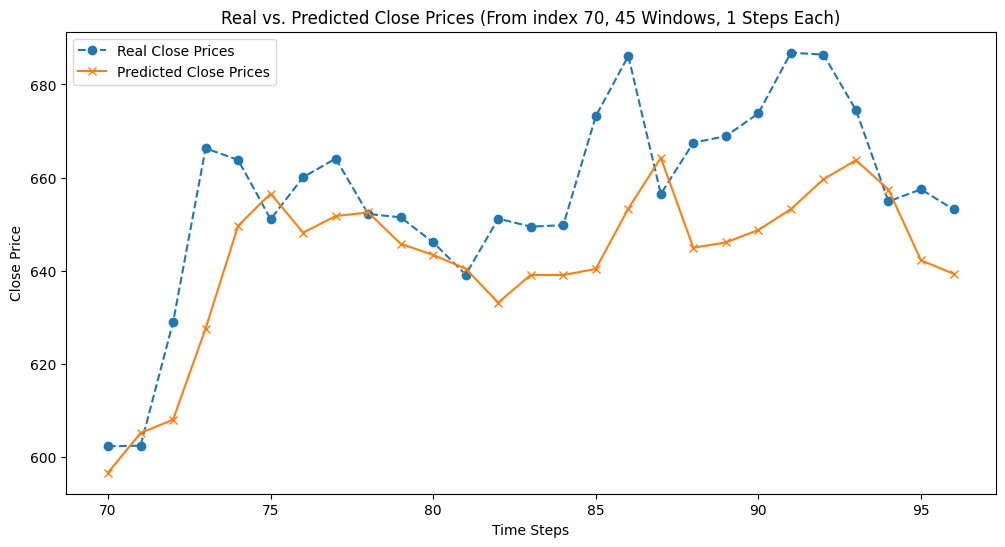

In [20]:
# -------------------------
# 4. Evaluate and Plot Results
# -------------------------
evaluate_model(trained_model, test_loader, scaler, feature_cols, target_col_idx,
               window_width=45, start_index=70, pred_length=1, device=device)